# Exercise session notes

SVD is a genralization of eigenvalue decomposition.

Given

$$ A = U \cdot D \cdot V^{T} $$

it holds that

$$ \left\{ \begin{array}{l}
    A \cdot V_i = d_i \cdot u_i\\
    A^{T} \cdot U_i = d_i \cdot v_i
\end{array}\right. 
\iff 
\left\{ \begin{array}{l}
    A \cdot A^{T} \cdot U_i = d_{i}^{2} u_{i} \\
    A^{T} \cdot A \cdot V_i = d_{i}^{2} v_{i} 
\end{array}\right. .$$

Exercise: prove that $r(\tilde{A}) = 2$, where $\tilde{A}_2 = U_2 \cdot D_2 \cdot V_2^T$.

# Problem 1 (SVD Theory)

In [75]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import copy
import random

In [ ]:
A = np.array([
        [8, 7,      1, np.NaN, 4],
        [9, 7,      2, 5,      6],
        [1, 4,      9, np.NaN, 3],
        [3, np.NaN, 8, 5,      4],
        [np.NaN, 3, np.NaN, 9, 9],
        [5, 1, 4, 10, np.NaN]
    ])

print(A.shape)

$A \in \mathbb{R}^{M \times N}$.

1. $ K = AA^{T}, K \in \mathbb{R}^{M \times M} $ indicates row-row correlations (movie-movie similarities). Every element (i, j) is just the dot product between movies i and j. Could consider using cosine similarity instead of the dot product in order not to get distracted by the absolute rating when computing similarities (movie pairs with higher ratings lead to larger dot products than equally similar movies but with lower ratings).
2. $ L = A^{T}A, L \in \mathbb{R}^{N \times N}$ indicates column-column correlations (user-user similarities).
3. $ A = UDV^{T}, U: (M \times M), D: (M \times N), V^{T}: (N \times N) $; in our case: $ U: (6 \times 6), D: (6 \times 5), V^{T}: (5 \times 5) $
4. Performing SVD on the rating column would help us isolate some latent concepts. It will, for instance, yield a matrix mapping movies to their belonging to a particular type (or genre), as well as one mapping users to their affinities towards certain genres. Main goal: low-rank approximation of original matrix. Compute missing ratings to use for recommending movies.
5. D contains the singular values $\sigma_{i}$ on its diagonal. It's possible to keep all nonzero singular values, but it's generally more useful to just keep the K largest ones. In our case, we could consider keeping the first three or two.
6. The matrix U can be seen as a description of every movie as a composition of some latent variables.
7. The matrix V can be seen as a description of every user as a composition of some latent variables (e.g. affinities to certain movie genres).

In [ ]:
A_imputed = np.nan_to_num(A)
A_imputed[A_imputed == 0] = 5.5
A_imputed

In [ ]:
def full_svd(matrix):
    """Utility which returns full SVD matrices.
    
    Works around the fact that numpy's SVD function returns the 'd'
    as a vector of singular values, instead of a diagonal matrix.
    """
    U, d, V = np.linalg.svd(matrix, full_matrices=True)
    D = np.zeros(matrix.shape)
    D[:d.shape[0],:d.shape[0]] = np.diag(d)
    return U, D, V

In [ ]:
U, D, V = full_svd(A_imputed)

In [ ]:
reconstruction = np.dot(U, np.dot(D, V))
reconstruction

In [ ]:
np.allclose(A_imputed, reconstruction)

In [ ]:
def scatter_label(data, labels):
    """Helper function for pretty scatterplots."""
    plt.scatter(data[:, 0], data[:, 1], s=60)
    for label, x, y in zip(labels, data[:, 0], data[:, 1]):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round, pad=0.5', fc = 'cyan', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [ ]:
U_2 = U[:,:2]
movie_labels = ['American Pie', 'Shrek', 'Titanic', 'The godfather', 'Avatar', 'Star Wars']
scatter_label(U_2, movie_labels)
    
_ = plt.title("8. Representations of movies using first two singular values.", 
              size=20, y=1.1)

We can interpret the above plot's X axis as a (sort-of) degree of realism, while the Y axis can be seen as a distinction between drama (positive) and comedy (negative).

In [ ]:
# Idea: analyze massive data and detect cultists who enjoy cult
# classics which some critics consider really bad (e.g. The Room, The Big Lebowski, etc.).

# Idea: analyze stuff user hasn't yet seen. Avoid stuff with very high or very low ratings.

V_2 = V[:,:2]
user_labels = ['Ben', 'Tom', 'John', 'Fred', 'Jack']
scatter_label(V_2, user_labels)

John and Jack prefer more serious movies, while Fred, Tom, and Ben are into comedies. Out of them, Fred seems to be the most well-rounded, but with still quite a strong inclination towards sci-fi.

The second singular value represents the comedy/drama division, while the first one seems to represent the degree of realism.

In [ ]:
A_approx = np.dot(U[:,:3], np.dot(D[:3,:], V))
print(A_imputed)
print(A_approx)
error = np.linalg.norm(A_approx - A_imputed)
print("Approximation error (frobenius): %f" % error)

## Bob wants to join the system!

In [ ]:
Bob = np.array([[1, np.NaN, np.NaN, 6, np.NaN, 10]])
Bob_imputed = np.nan_to_num(Bob)
Bob_imputed[Bob_imputed == 0] = 5.5
Bob_imputed

In [ ]:
# TODO(andrei) Do this in a prettier way.
A_bob_imputed = np.hstack((A_imputed, Bob_imputed.T))
A_bob_imputed

In [ ]:
U, D, V = full_svd(A_bob_imputed)
scatter_label(U[:,:2], movie_labels)

In [ ]:
user_labels.append('Bob')
scatter_label(V[:,:2], user_labels)

Bob seems to be close to Fred, in that he also likes more serous movies, but he's even farther than the rest since he absolutely hates comedies such as American Pie.

In [ ]:
A_bob_approx = np.dot(U[:,:3], np.dot(D[:3,:], V))
print("Approximate rating matrix including Bob:\n\n", A_bob_approx, "\n")
error_frob = np.linalg.norm(A_approx - A_imputed, ord='fro')
error_euclid = np.linalg.norm(A_approx - A_imputed, ord=2)

print(("Approximation errors after adding Bob to system:\n" +
      "\t- Frobenius norm: %f\n" +
      "\t- Euclidean norm: %f\n") % (error_frob, error_euclid))

We use the highest predicted rating which was missing in Bob's original ratings in order to recommend him a movie.

In [ ]:
# Get Bob's rating column!
bob_index = user_labels.index('Bob')
Bob_new_ratings = A_bob_approx[:, bob_index]

# Keep track of the original row indices in the column...
Bob_candidates = np.array([np.arange(Bob.shape[1]), Bob_new_ratings])
# ...and only keep rows for movies Bob didn't see yet.
Bob_candidates = Bob_candidates[:, np.isnan(Bob[0])]

# Pick the row with the highest rating.
best_entry = Bob_candidates[:, np.argmax(Bob_candidates[1,:])]
# And then grab the movie index.
best_index = int(best_entry[0])

print("Bob should watch %s!" % movie_labels[best_index])

In closing, Bob's ratings do affect our prediction system, since they add more information (and also a little bit more confusion, due to a slightly larger approximation error) to our data matrix.

# Problem 2: Collaborative Filtering

In [38]:
def load_ratings(data_file):
    """Loads the rating data from the specified file. 
    
    Does not yet build the rating matrix. Use 'ratings_to_matrix' to do that.
    Assumes the file has a header (which is ignored), and that the ratings are
    then specified as 'rXXX_cXXX,X', where the 'X' blanks specify the row, the
    column, and then the actual (integer) rating.
    """
    ratings = []
    with open(data_file, 'r') as file:
        header = file.readline()
        # print("Header: %s" % header)
        for line in file:
            key, value_string = line.split(",")
            rating = int(value_string)
            row_string, col_string = key.split("_")
            row = int(row_string[1:])
            col = int(col_string[1:])
            
            if rating < 1 or rating > 5:
                raise ValueError("Found illegal rating value [%d]." % rating)
            
            ratings.append((row - 1, col - 1, rating))
            
    return ratings

def ratings_to_matrix(ratings, matrix_rows, matrix_cols):
    """Converts a list of ratings to a numpy matrix."""
    print("Building [%d x %d] rating matrix." % (matrix_rows, matrix_cols))
    matrix = np.zeros([matrix_rows, matrix_cols])
    for (row, col, rating) in ratings:
        matrix[row, col] = rating
        
    print("Finished building rating matrix.")
    return matrix

In [39]:
# Rows are users
USER_COUNT = 10000

# Columns are items
ITEM_COUNT = 1000

VALIDATION_RATIO = 0.1
TRAINING_RATIO = 1 - VALIDATION_RATIO

In [40]:
RANDOM_SEED = 0xC0FFEE
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [41]:
all_ratings = load_ratings('data/cf/data_train.csv')

In [42]:
data_matrix = ratings_to_matrix(all_ratings, USER_COUNT, ITEM_COUNT)

Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [43]:
all_ratings_count = len(all_ratings)
print("We have [%d] data points." % all_ratings_count)

validation_count = int(VALIDATION_RATIO * all_ratings_count)
training_count = all_ratings_count - validation_count
print("Will use [%d] data points for validation, and [%d] for training." %
     (validation_count, training_count))

We have [1388107] data points.
Will use [138810] data points for validation, and [1249297] for training.


In [44]:
def shuffle_split_data(all_data, training_count, validation_count):
    """Returns a split consisting of (training, validation) data, created
    after shuffling the input data.
    """
    to_shuffle = copy.copy(all_data)
    random.shuffle(to_shuffle)
    return to_shuffle[:training_count], to_shuffle[training_count:]

In [45]:
train, validation = shuffle_split_data(all_ratings, training_count, validation_count)
train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
validation_matrix = ratings_to_matrix(validation, USER_COUNT, ITEM_COUNT)

assert len(train_matrix[train_matrix != 0]) == training_count
assert len(validation_matrix[validation_matrix != 0]) == validation_count

Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.


In [46]:
def score_predictions(prediction_matrix, validation_matrix):
    """Computes the RMSE score for the prediction matrix based
    on the data points present in the validation matrix.
    
    """
    
    # Want to compute RMSE just for nonzero validation elements.
    mask = (validation_matrix != 0)
    count = np.sum(mask)
    actual = prediction_matrix[mask]
    real = validation_matrix[mask]
    
    delta = np.abs(actual - real)
    delta = delta * delta
    delta = np.sum(delta)
    
    score = np.sqrt(delta / count)
    return score


def score_predictions_slow(prediction_matrix, validation_matrix):
    s = 0
    count = 0 #np.sum(validation_matrix > 0)
    for row in range(validation_matrix.shape[0]):
        for col in range(validation_matrix.shape[1]):
            if validation_matrix[row, col] > 0:
                delta = (validation_matrix[row, col] - prediction_matrix[row, col]) ** 2
                s += delta
                count += 1
                
    score = np.sqrt(s * 1.0 / count)
    return score

In [47]:
def predict_by_avg_item_rating(data):
    # Assume every product has at least one rating.
    # A product is represented by a column
    nonzero = (data != 0)
    rating_counts = nonzero.sum(1)
    rating_sums = data.sum(1)
    item_ratings = rating_sums / rating_counts
    predictions = np.copy(data)
    for col in range(data.shape[1]):
        no_rating = (predictions[:, col] == 0)
        predictions[no_rating, col] = item_ratings[col]

    zero_pred = (predictions == 0)
    assert np.sum(zero_pred) == 0
    return predictions


no_svd_result = predict_by_avg_item_rating(train_matrix)
print("No-SVD RMSE: %.4f" % score_predictions(no_svd_result, validation_matrix))
# print("RMSE: %.4f" % score_predictions_slow(no_svd_result, validation_matrix))

No-SVD RMSE: 1.1820


In [48]:
def svd_predict(data, k=290, sanity_check=False):
    """Predict the missing values in the data matrix using SVD.
    
    Imputes the missing values using column-wise means, and then improves the
    prediction using singular value decomposition.
    
    Arguments:
        data: The data matrix with missing values on which to apply SVD.
        k: The number of singular values to keep.
        sanity_check: Whether to perform additional (potentially slow) sanity checks.
    """
    # Note: this function does not apply the 'sqrt(D)' pre-multiplication
    # trick specified in the exercise sheet, as it led to a strange (and
    # likely silly) bug.
    
    imputed = predict_by_avg_item_rating(data)
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    # This ensures that our variables correspond with the notation in
    # the slides and homework sheets.
    V = V.T
    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)
#     U_prime = np.dot(U, np.sqrt(D))
#     V_prime = np.dot(np.sqrt(D), V)
    
    if sanity_check:
        reconstruction = np.dot(U, np.dot(D, V.T))
        assert np.allclose(reconstruction, imputed)
        
#         rec_2 = np.dot(U_prime, V_prime.T)
#         assert np.allclose(rec_2[:,:1000], imputed)
    
# There's probably a very simple explanation for why this is fucking up.

#     U_prime_lim = U_prime[:,:k]
#     V_prime_lim = V_prime[:,:k]

#     k_prediction = np.dot(U_prime_lim, V_prime_lim.T)

    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:, :]
    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    
    return k_prediction

In [ ]:
# Reuse previous prediction
imputed = no_svd_result

U, d, V = np.linalg.svd(imputed, full_matrices=True)
V = V.T

In [ ]:
D = np.zeros_like(imputed)
D[:d.shape[0], :d.shape[0]] = np.diag(d)

In [ ]:
# A few sanity checks for various values of k (singular values kept).

errors = []
means = []
ks = range(10, 1000, 25)
for k in ks:
    U_k = U[:, :k]
    D_k = D[:k, :]
    V_k = V[:, :]

    recon_k = np.dot(U_k, np.dot(D_k, V_k.T))
    fro = np.linalg.norm(recon_k - imputed)
    errors.append(fro)
    means.append(np.mean(recon_k))

In [ ]:
plt.plot(ks, errors)
plt.xlabel("kept singular values")
plt.ylabel("approximation error (Frobenius norm)")

In [ ]:
# Sanity
plt.plot(ks, means)

In [ ]:
# Plot the singular value spectrum
plt.plot(np.arange(15), d[:15])

In [ ]:
fun_prediction = svd_predict(train_matrix)
fun_prediction_10 = svd_predict(train_matrix, k=10)

In [ ]:
print("Item rating prediction score: %.8f" % score_predictions(no_svd_result, validation_matrix))
print("SVD prediction score (k=default): %.8f" % score_predictions(fun_prediction, validation_matrix))
print("SVD prediction score (k=10): %.8f" % score_predictions(fun_prediction_10, validation_matrix))

# Some sanity checks
print("Should be 0: ", score_predictions(data_matrix, validation_matrix))
print("Should be 0: ", score_predictions(validation_matrix, validation_matrix))
print("Should be big: ", score_predictions(train_matrix, validation_matrix))

In [ ]:
rmses = []
for k in range(5, 20, 1):
    U_lim = U[:,:k]
    D_lim = D[:k, :]
    V_lim = V[:,:]

    k_prediction = np.dot(U_lim, np.dot(D_lim, V_lim.T))
    k_prediction = k_prediction[:, :1000]
    rmses.append((k, score_predictions(k_prediction, validation_matrix)))

In [ ]:
plt.plot([e[0] for e in rmses], [e[1] for e in rmses])
plt.xlabel("Number of kept singular values $\sigma$")
plt.ylabel("RMSE on validation set")

In [ ]:
for (k, err) in rmses:
    print("%d: %.6f" % (k, err))

# Cross-validation (experimental)

In [49]:
from sklearn.cross_validation import KFold

In [62]:
CV_FOLDS = 5
folds = KFold(len(all_ratings), n_folds=CV_FOLDS, shuffle=True)

# TODO(andrei) Implement predictions as a subclass of BaseEstimator
# and/or RegressionEstimator so we can use it with e.g. grid searches.

k = 3

# A 2D array where every row is a data point. The first column specifies
# the row in the data matrix where the rating belongs, the second column,
# its column. The third one is the actual rating.
all_ratings_np = np.array(all_ratings)
all_ratings_np.shape

(1388107, 3)

In [63]:
# We will not use 'svd_predict' and instead we will use a dirty trick
# to significantly speed up our cross-validation scores.

# For every fold, results will contain a list of len(ks) scores.
# This is an unorthodox way of doing CV, but it's much faster since
# we only do one SVD per fold, instead of one per (k * folds).
results = []

ks = range(1, 30, 1)
for train_index, test_index in folds:
    train = all_ratings_np[train_index]
    test = all_ratings_np[test_index]
     
    train_matrix = ratings_to_matrix(train, USER_COUNT, ITEM_COUNT)
    test_matrix = ratings_to_matrix(test, USER_COUNT, ITEM_COUNT)
    
    print("Performing naive imputation...")
    imputed = predict_by_avg_item_rating(train_matrix)
    print("Performing SVD...")
    U, d, V = np.linalg.svd(imputed, full_matrices=True)
    print("SVD done.")
    V = V.T

    D = np.zeros_like(imputed)
    D[:d.shape[0], :d.shape[0]] = np.diag(d)

    rmses = []
    for k in ks:
        U_k = U[:, :k]
        D_k = D[:k, :]
        V_k = V[:, :]
        
        k_prediction = np.dot(U_k, np.dot(D_k, V_k.T))
        k_prediction = k_prediction[:, :1000]
        rmses.append((k, score_predictions(k_prediction, test_matrix)))

    results.append(rmses)
    
print("Done.")

3.6644141974
3.66323634294
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing naive imputation...
Performing SVD...
SVD done.
3.66344975394
3.66709410637
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing naive imputation...
Performing SVD...
SVD done.
3.66487826051
3.66138008292
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing naive imputation...
Performing SVD...
SVD done.
3.66360674515
3.6664661535
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Building [10000 x 1000] rating matrix.
Finished building rating matrix.
Performing naive imputation...
Performing SVD...
SVD done.
3.66454417255
3.66271643716
Building [10000 x 1000] rating matrix.
Finished bu

In [69]:
cv_rmses = []
for index, k in enumerate(ks):
    score = 0
    for fold in range(CV_FOLDS):
        score += results[fold][index][1]
        
    avg_score = score / CV_FOLDS
    cv_rmses.append(avg_score)

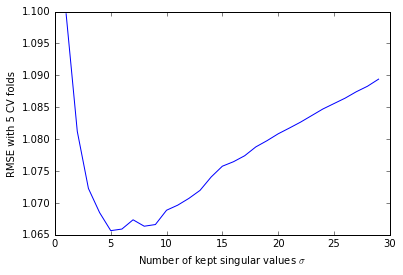

In [70]:
plt.plot(ks, cv_rmses)
plt.ylabel("RMSE with %d CV folds" % CV_FOLDS)
plt.xlabel("Number of kept singular values $\sigma$")

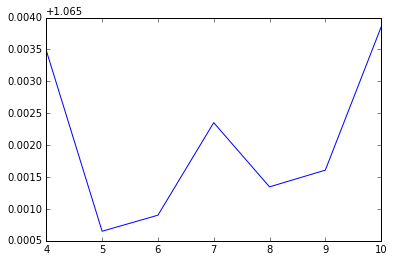

In [66]:
plt.plot(ks[3:10], cv_rmses[3:10])

# Kaggle test data output stuff

In [72]:
test_result = svd_predict(data_matrix, k=5)

In [73]:
import os
import time

def output_solution(solution_matrix):
    submisson_template = load_ratings('data/cf/sampleSubmission.csv')
    output = "Id,Prediction\n"
    for (row, col, _) in submisson_template:
        output += "r%d_c%d,%f\n" % (row + 1, col + 1, solution_matrix[row, col])
                
    return output

def output_solution_to_file(solution_matrix, technique, output_root='out/cf'):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_name = "submission-%s-%s.csv" % (technique, timestr)
    file_path = os.path.join(output_root, file_name)
    with open(file_path, 'w') as output_file:
        output_text = output_solution(solution_matrix)
        output_file.write(output_text)

In [74]:
output_solution_to_file(test_result, "vanilla")